# 1. EDA and Preprocessing

In [5]:
import os
import glob
import time
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from tqdm import tqdm

### 1. PATH set

In [2]:
# Data from AI HUB
BASE_DIR = r"E:\한국인 감정인식을 위한 복합 영상"
TRAIN_PATH = os.path.join(BASE_DIR, "Training")
TEST_PATH = os.path.join(BASE_DIR, "Validation")
NEW_BASE = r"E:\PCP"

### 2. ZIP Extract

In [151]:
# Train ZIP
train_label_list = [label for label in os.listdir(TRAIN_PATH) if "[라벨]" in label]
train_source_list = [source for source in os.listdir(TRAIN_PATH) if "[원천]" in source]
# Test ZIP
test_label_list = [label for label in os.listdir(TEST_PATH) if "[라벨]" in label]
test_source_list = [source for source in os.listdir(TEST_PATH) if "[원천]" in source]

In [4]:
# 한국어 인코딩 적용 후, 압축 해제
def unzip_kor(source_file: str, dest_path: str)->None:
    with zipfile.ZipFile(source_file, "r") as zf:
        zipInfo = zf.infolist()
        for member in zipInfo:
            member.filename = member.filename.encode("cp437").decode("euc-kr")
            zf.extract(member, dest_path)

In [20]:
# Train Label
for zip_path in tqdm(train_label_list):
    zip_path = os.path.join(TRAIN_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, "Train_Label"))
# Test Label
for zip_path in tqdm(test_label_list):
    zip_path = os.path.join(TEST_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, "Test_Label"))

100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


In [5]:
# Train Source
for zip_path in tqdm(train_source_list):
    dir_name = zip_path[11:13]
    zip_path = os.path.join(TRAIN_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, os.path.join("Train", dir_name)))
# Test Source
for zip_path in tqdm(test_source_list):
    dir_name = zip_path[11:13]
    zip_path = os.path.join(TEST_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, os.path.join("Test", dir_name)))

100%|██████████| 7/7 [48:27<00:00, 415.42s/it]


### 3. EDA
게시자 ID Hash_성별_연령_감정_배경_업로드 번호 

In [81]:
# conver DataFrame
train_df = []
for train in os.listdir(NEW_BASE+"/Train"): train_df.append(pd.DataFrame({"PATH":os.listdir(NEW_BASE+f"/Train/{train}")}))
train_df = pd.concat(train_df, axis=0)
train_df = train_df.reset_index(drop=True)
train_df = pd.concat([train_df, train_df["PATH"].str.split("_", expand=True).iloc[:, 1:4].rename(columns={1:"성별", 2:"나이", 3:"Label"})], axis=1)

test_df = []
for test in os.listdir(NEW_BASE+"/Test"): test_df.append(pd.DataFrame({"PATH":os.listdir(NEW_BASE+f"/Test/{test}")}))
test_df = pd.concat(test_df, axis=0)
test_df = test_df.reset_index(drop=True)
test_df = pd.concat([test_df, test_df["PATH"].str.split("_", expand=True).iloc[:, 1:4].rename(columns={1:"성별", 2:"나이", 3:"Label"})], axis=1)

print(f"Cols: {train_df.columns.tolist()}\nTrain: {train_df.shape}\nTest: {test_df.shape}")

Cols: ['PATH', '성별', '나이', 'Label']
Train: (417052, 4)
Test: (52139, 4)


In [102]:
# Save DF
train_df.to_csv("../Ref_Data/emtion_train.csv", encoding="utf8", index=False)
test_df.to_csv("../Ref_Data/emotion_test.csv", encoding="utf8", index=False)

### 4. EDA
#### 4-1. 전체 라벨 분포

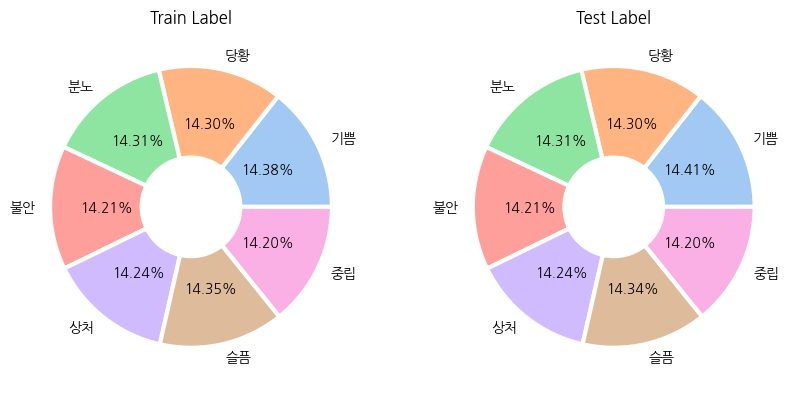

In [215]:
train_gb = train_df.groupby("Label")["PATH"].count()
test_gb = test_df.groupby("Label")["PATH"].count()

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
wedgeprops = {"width":0.65, "edgecolor":"w", "linewidth":3}
cp = sns.color_palette("pastel", n_colors=7)
fontdict = {"weight":"bold"}

ax[0].pie(train_gb.values, labels=train_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[0].set_title("Train Label", fontdict=fontdict)

ax[1].pie(test_gb.values, labels=test_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[1].set_title("Test Label", fontdict=fontdict)

plt.show()

#### 4-2. 라벨별 샘플

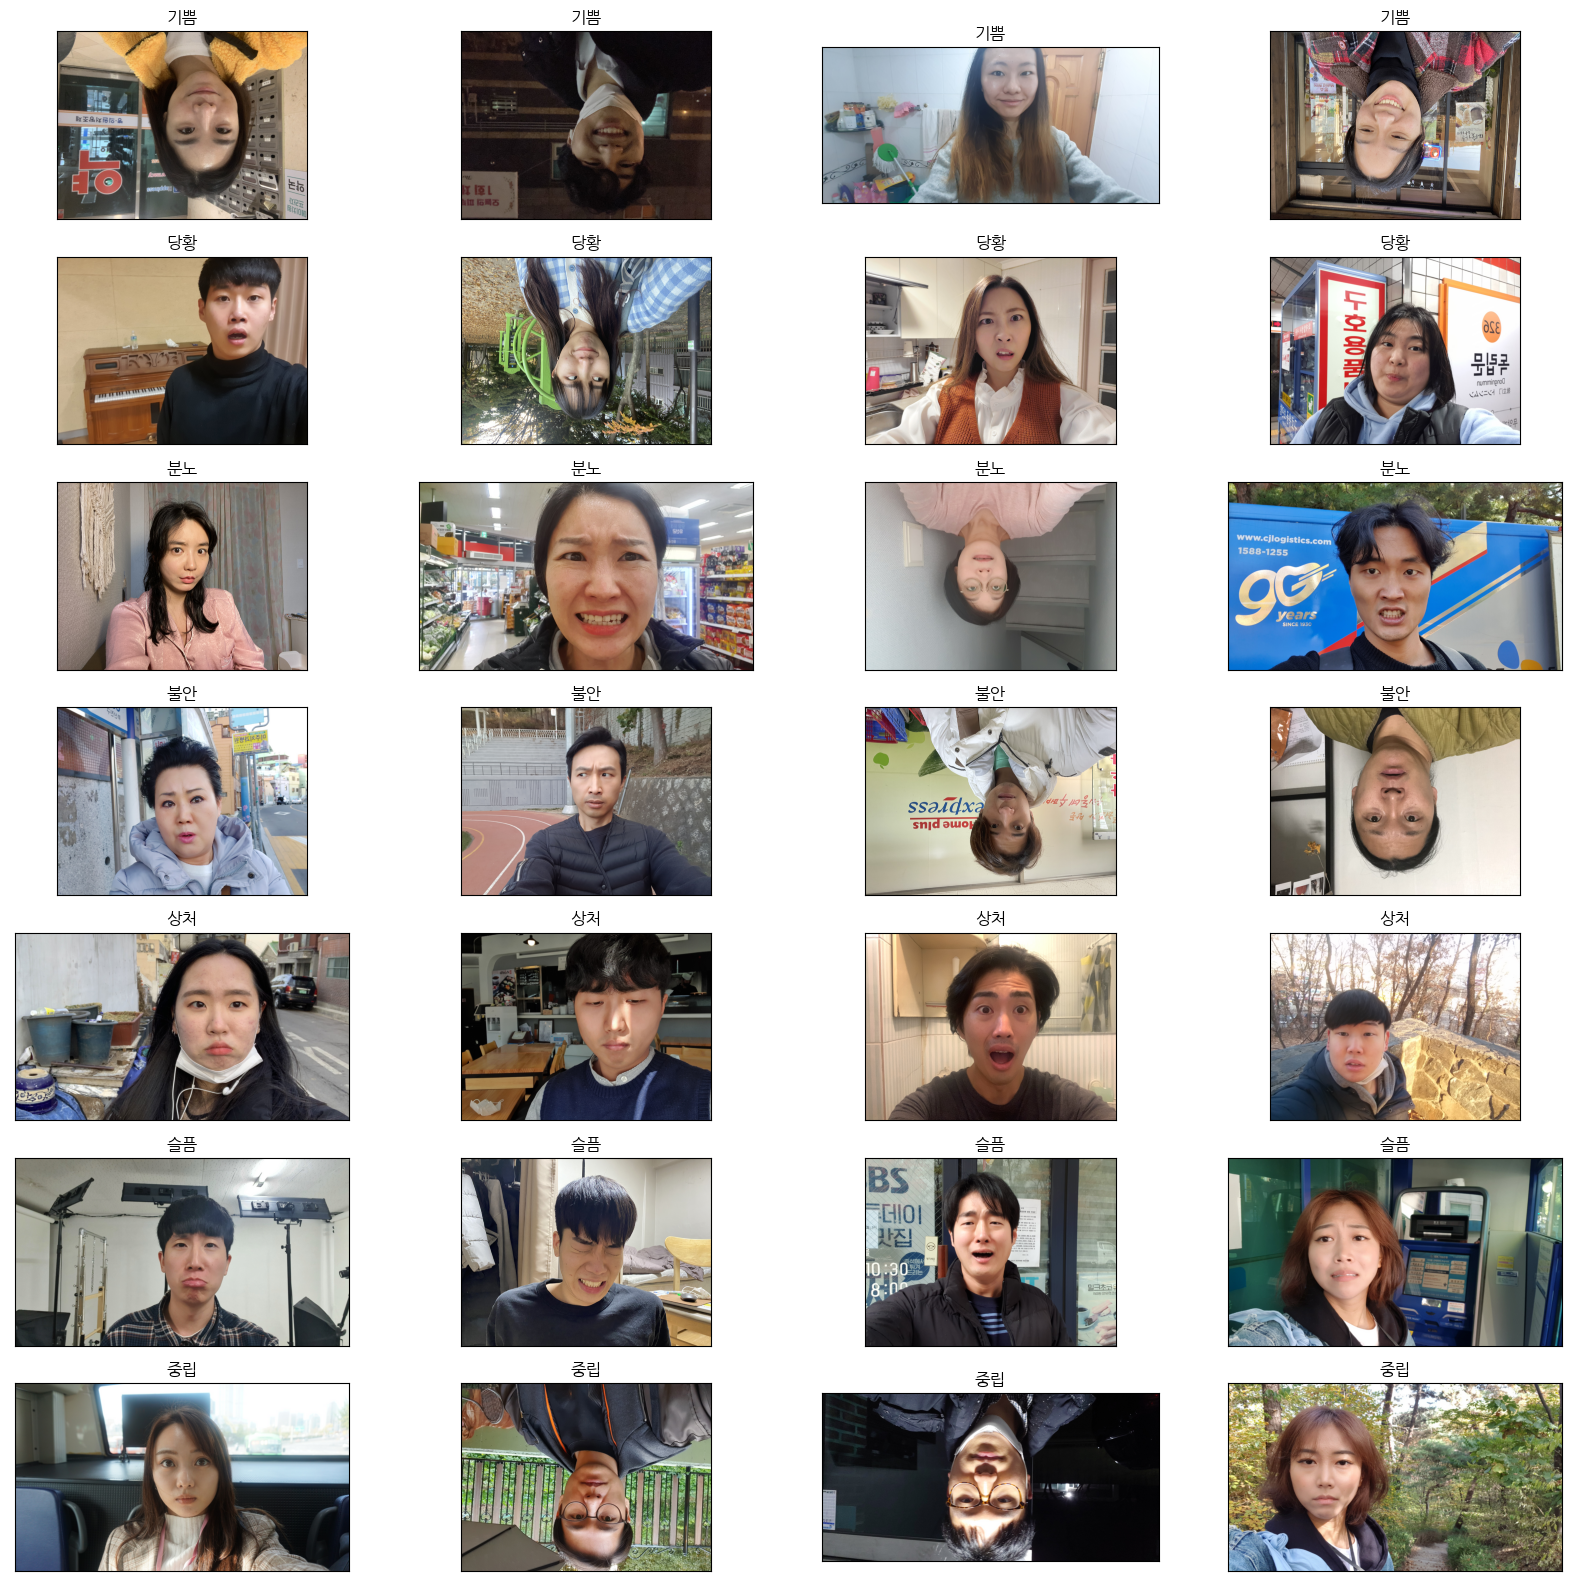

In [191]:
labels = os.listdir(NEW_BASE+"/Train")
plt.figure(figsize=(20, 20))
idx = 0
for ridx in range(0, len(labels)):
    for cidx in range(0, 4):
        emotion_sample = train_df[train_df["Label"]==labels[ridx]].sample(1)
        plt.subplot(7, 4, idx+1)
        plt.imshow(plt.imread(os.path.join(NEW_BASE, "Train", labels[ridx], emotion_sample["PATH"].values[0])))
        plt.title(emotion_sample["Label"].values[0])
        plt.xticks([])
        plt.yticks([])
        idx += 1

#### 4.3 나이별 분포

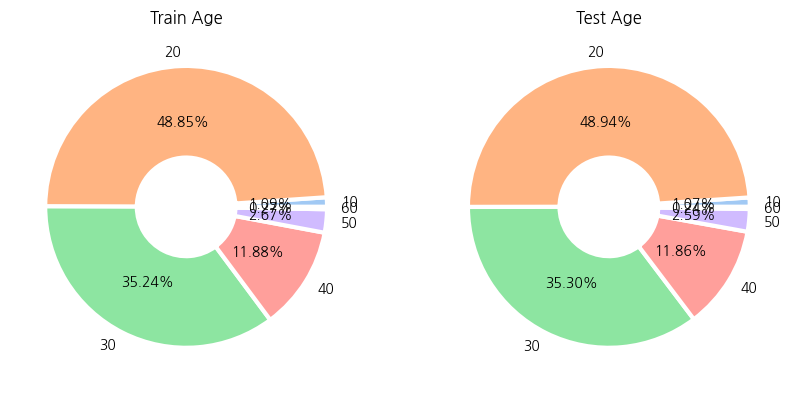

In [214]:
train_gb = train_df["나이"].value_counts().sort_index()
test_gb = test_df["나이"].value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
wedgeprops = {"width":0.65, "edgecolor":"w", "linewidth":3}
cp = sns.color_palette("pastel", n_colors=7)
fontdict = {"weight":"bold"}

ax[0].pie(train_gb.values, labels=train_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[0].set_title("Train Age", fontdict=fontdict)

ax[1].pie(test_gb.values, labels=test_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[1].set_title("Test Age", fontdict=fontdict)

plt.show()

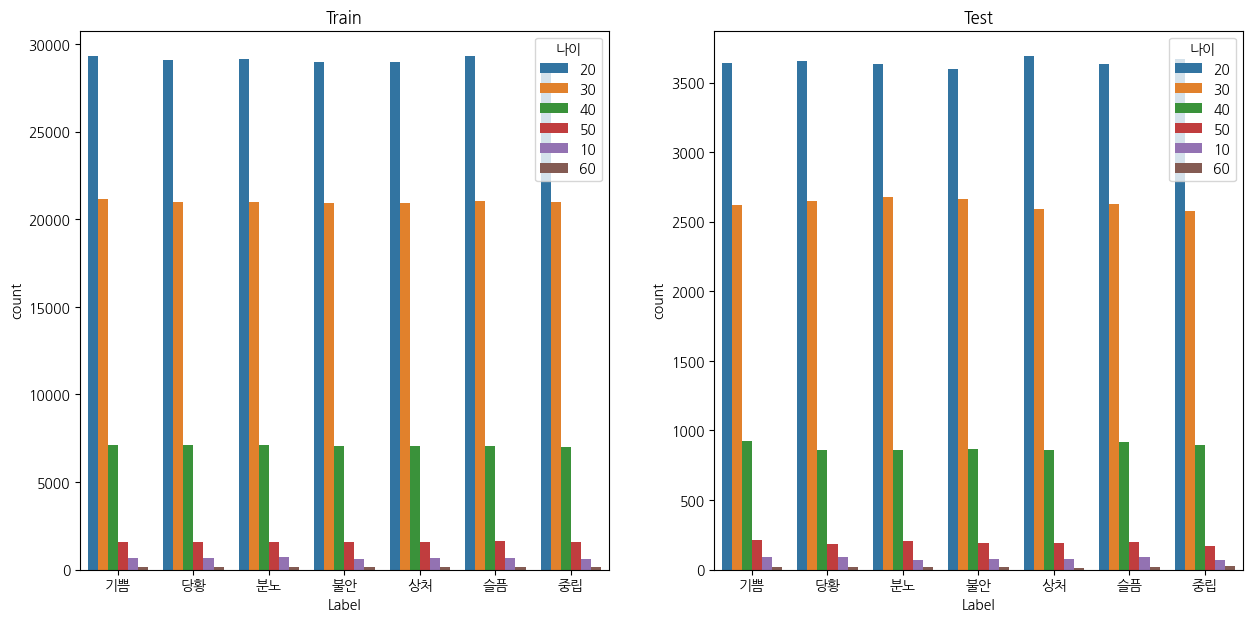

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.countplot(train_df, x="Label", hue="나이", ax=ax[0]).set_title("Train")
sns.countplot(test_df, x="Label", hue="나이", ax=ax[1]).set_title("Test")
plt.show()

#### 4.4 성별 분포

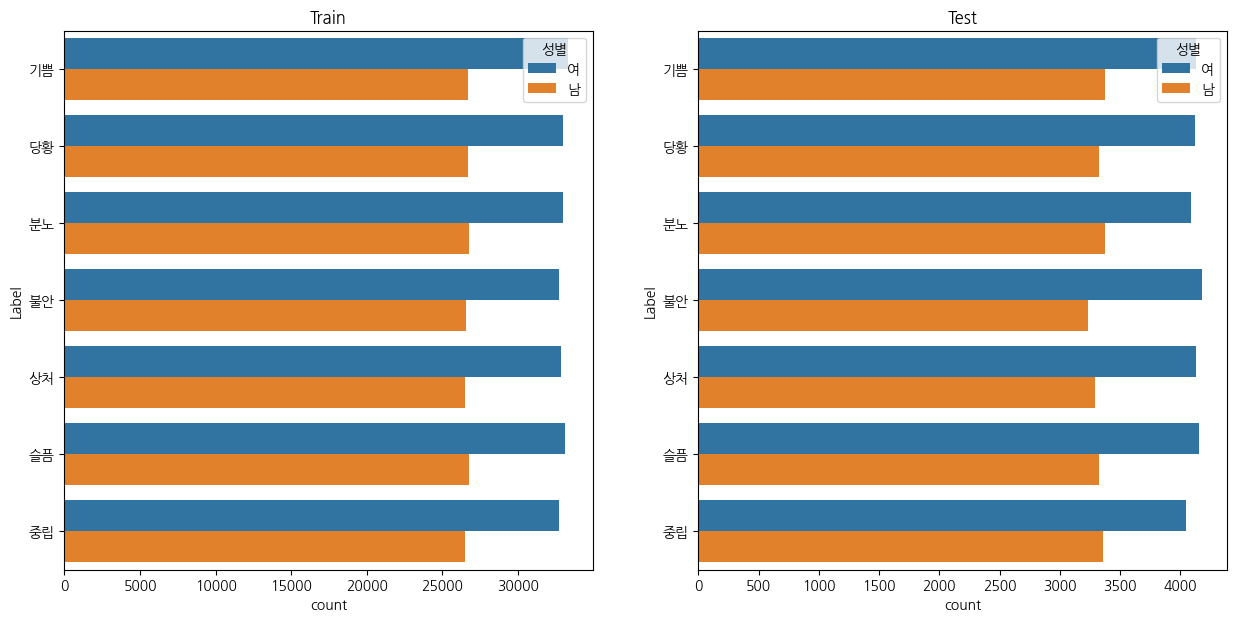

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.countplot(train_df, y="Label", hue="성별", ax=ax[0]).set_title("Train")
sns.countplot(test_df, y="Label", hue="성별", ax=ax[1]).set_title("Test")
plt.show()